<a href="https://colab.research.google.com/github/Pludaggerto/LearnAndTest/blob/main/code/demoMCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 MCMC

MCMC方法是用来在概率空间，**通过随机采样估算兴趣参数**的后验分布。



## 1.1 动机
- 解决概率密度函数不可积以及累积分布函数没有反函数时的应用
    - 反函数是因为MC中，用均匀分布计算F(x)，然后求解$x_i = F^{-1}(i)$
- 解决维数灾难



# 2 蒙特卡罗



## 2.1 Box-Muller变换
正态分布可由随机分布生成

NormaltestResult(statistic=3.755000254631634, pvalue=0.1529720387872138)

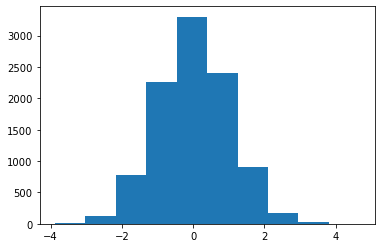

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
a = np.random.uniform(0,1,(10000))
b = np.random.uniform(0,1,(10000))
z = np.sqrt(-2*np.log(a)) * np.cos(2* np.pi * b)
plt.hist(z)
scipy.stats.normaltest(z)

## 2.2 拒绝接受采样
- 需求： 根某已知分布的概率密度函数$f(x)$，产生服从此分布的样本$X$。
- 准备
    - 需要辅助的建议分布$G$
    - 辅助的均匀分布$U(0,1)$
    - 计算常数$c$，使得$cg(x) \geq f(x)$的最小值
- 过程
    - 从建议分布$G$抽样，得到样本$Y$
    - 从$U(0,1)$抽样，得到样本$D$
    - 如果$D \leq \frac{f(Y)}{c * g(Y)}$，则令$X = Y$(接受Y)，否则继续执行步骤1（拒绝）。

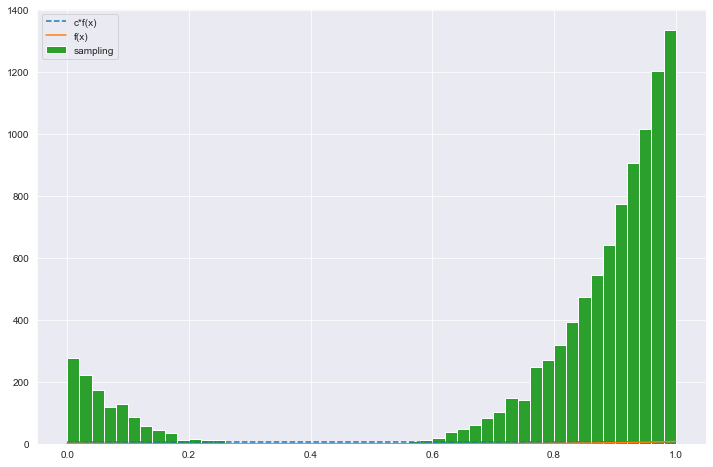

In [1]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


def AceeptReject(split_val):
    global c
    global power
    while True:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        if y*c <= math.pow(x - split_val, power):
            return x

power = 4
t = 0.4  
sum_ = (math.pow(1-t, power + 1) - math.pow(-t, power + 1)) / (power + 1)  #求积分
x = np.linspace(0, 1, 100)
#常数值c
c = 0.6**4/sum_
cc = [c for xi in x]
plt.plot(x, cc, '--',label='c*f(x)')
#目标概率密度函数的值f(x)
y = [math.pow(xi - t, power)/sum_ for xi in x]
plt.plot(x, y,label='f(x)')
#采样10000个点
samples = []
for  i in range(10000):
    samples.append(AceeptReject(t))
plt.hist(samples, bins=50,label='sampling')
plt.legend()
plt.show()

## 2.3 蒙特卡罗方法小结
使用接受-拒绝采样，我们可以解决一些概率分布不是常见的分布的时候，得到其采样集并用蒙特卡罗方法求和得到。但是接受-拒绝采样也只能部分满足我们的需求，在很多时候我们还是很难得到我们的概率分布的样本集。比如之前的第一个问题有时可以解决，但又会产生另一个问题：

- 对于一些二维分布$p(x, y)$，我们只能得到条件分布$p(x|y)，p(y|x)$，却不能得到二维分布的一般形式；

- 对于复杂非常见分布$p(x_1,..., x_n)$，我们很难找到合适的$q(x),c$，

要想将蒙特卡罗方法作为一个通用的采样模拟求和的方法，还需马尔科夫链的帮忙。

# 3 马尔可夫链
马尔科夫链定义本身比较简单，它假设某一时刻状态转移的概率只依赖于它的前一个状态。

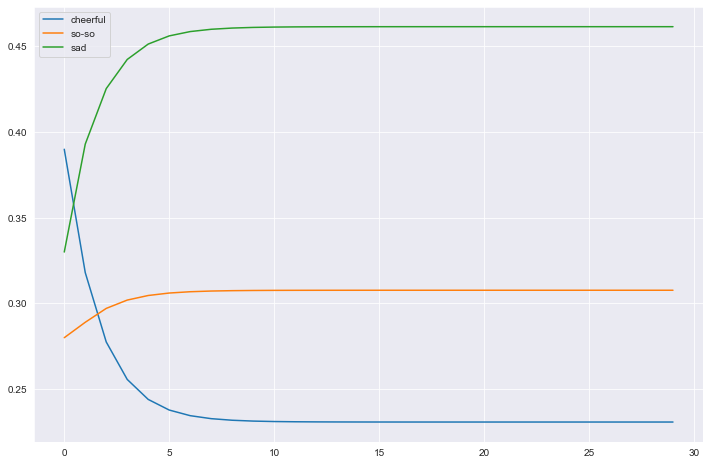

In [ ]:
transfer_matrix = np.array([[0.6,0.2,0.2],[0.3,0.4,0.3],[0,0.3,0.7]],dtype='float32')
start_matrix = np.array([[0.5,0.3,0.2]],dtype='float32')

value1 = []
value2 = []
value3 = []
for i in range(30):
    start_matrix = np.dot(start_matrix,transfer_matrix)
    value1.append(start_matrix[0][0])
    value2.append(start_matrix[0][1])
    value3.append(start_matrix[0][2])

x = np.arange(30)
plt.plot(x,value1,label='cheerful')
plt.plot(x,value2,label='so-so')
plt.plot(x,value3,label='sad')
plt.legend()
plt.show()

马尔科夫链模型的状态转移矩阵收敛到的稳定概率分布与我们的初始状态概率分布无关。也就是说，如果我们得到了这个稳定概率分布对应的马尔科夫链模型的状态转移矩阵，则我们可以用任意的概率分布样本开始，带入马尔科夫链模型的状态转移矩阵，这样经过一些序列的转换，最终就可以得到符合对应稳定概率分布的样本。
## 3.1 平稳分布
平稳分布：经过一步概率转移后分布保持不变
$$
\pi  = \pi P
$$
对于一个不可约的马尔可夫链，如果是遍历的，那么任何初始状态在足够长的时间后，都会变成平稳分布。



## 3.2 马尔可夫链采样MCMC
### 3.2.1 原理
提高了采样的效率。
对于随机矩阵$Q$，引入$\alpha$，使得
$$
\pi(i) = Q(i,j) \alpha(i,j)
$$
与MC采样类似，通过随机转移矩阵$Q$进行采样，但是样本被保留下来继续抽样的概率为$\alpha$。
$$
\alpha(i, j)=\min \left\{\frac{\pi(j) Q(j, i)}{\pi(i) Q(i, j)}, 1\right\}\
$$

### 3.2.2步骤
- 给定转移矩阵$Q$，平稳分布$\pi(x)$
- t=0随机产生一个初始状态$x_0$
- 从条件概率分布$Q(x|x_0)$中采样$x^*$
- 从均匀分布产生u~U(0,1)
- 若$u < \alpha(x_0, x^*) = \min {\frac{\pi(j) Q(j, i)}{\pi(i)Q(i, j)}}$，接受$x^* \rightarrow t = 1, x_1 = x^*$，否则拒绝该次采样，$t = 1, x_1 = x_0$
- 继续以上步骤，直到$t>T$时，达到平衡。
- t > T 之后所有接受样本即需要的平稳分布样本


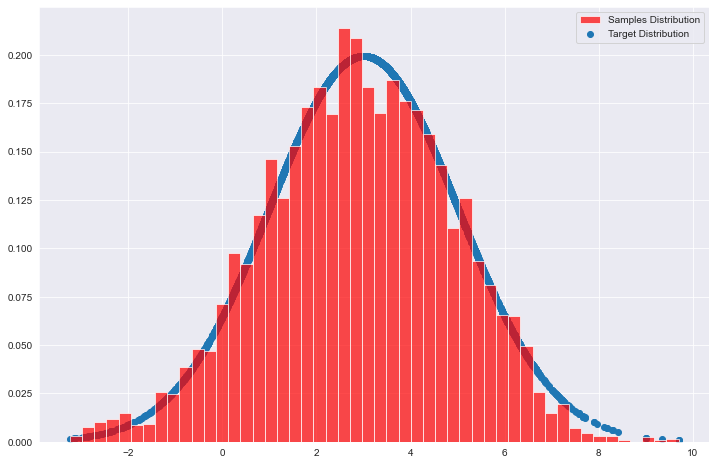

In [ ]:
from scipy.stats import norm

def norm_dist_prob(theta):
    y = norm.pdf(theta, loc=3, scale=2)
    return y

T = 5000
pi = [0 for i in range(T)]
sigma = 1
t = 0
while t < T-1:
    t = t + 1
    pi_star = norm.rvs(loc=pi[t - 1], scale=sigma, size=1, random_state=None)   #状态转移进行随机抽样
    alpha = min(1, (norm_dist_prob(pi_star[0]) / norm_dist_prob(pi[t - 1])))   #alpha值

    u = random.uniform(0, 1)
    if u < alpha:
        pi[t] = pi_star[0]
    else:
        pi[t] = pi[t - 1]


plt.scatter(pi, norm.pdf(pi, loc=3, scale=2),label='Target Distribution')
num_bins = 50
plt.hist(pi, num_bins, density=1, stacked=True, facecolor='red', alpha=0.7,label='Samples Distribution')
plt.legend()
plt.show()

## 3.3吉布斯采样
### 3.3.1 原理
解决在高维参数空间上，接受概率过小的问题。
### 3.3.2 步骤
- 给定平稳分布 $\pi(x_1,x_2)$
- $t = 0$随机产生一个初始状态$(x_1^{(0)}, x_2^{(0)})$
- 从条件概率分布$P(x_2|x_1^{0})$中采样$(x_1^{0}, x_2^{1})$
- 从条件概率分布$P(x_1|x_2{(1)})$中采样$(x_1^{1}, x_2^{1})$
- 不停轮换坐标轴，采取指定数量样本为止。

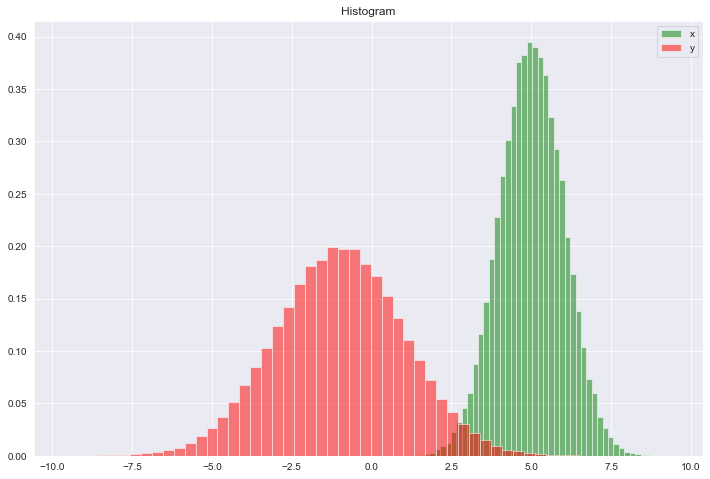

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

samplesource = multivariate_normal(mean=[5,-1], cov=[[1,0.5],[0.5,2]])

def p_ygivenx(x, m1, m2, s1, s2):
    return (random.normalvariate(m2 + rho * s2 / s1 * (x - m1), math.sqrt(1 - rho ** 2) * s2))

def p_xgiveny(y, m1, m2, s1, s2):
    return (random.normalvariate(m1 + rho * s1 / s2 * (y - m2), math.sqrt(1 - rho ** 2) * s1))

N = 5000
K = 20
x_res = []
y_res = []
z_res = []
m1 = 5
m2 = -1
s1 = 1
s2 = 2

rho = 0.5
y = m2

for i in range(N):
    for j in range(K):
        x = p_xgiveny(y, m1, m2, s1, s2)   #y给定得到x的采样
        y = p_ygivenx(x, m1, m2, s1, s2)   #x给定得到y的采样
        z = samplesource.pdf([x,y])
        x_res.append(x)
        y_res.append(y)
        z_res.append(z)

num_bins = 50
plt.hist(x_res, num_bins, density=1, stacked=True, facecolor='green', alpha=0.5,label='x')
plt.hist(y_res, num_bins, density=1, stacked=True, facecolor='red', alpha=0.5,label='y')
plt.title('Histogram')
plt.legend()
plt.show()

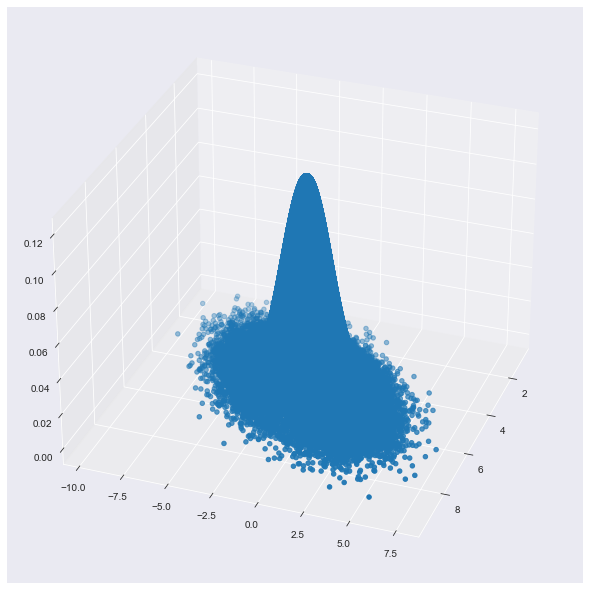

In [ ]:
fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
ax.scatter(x_res, y_res, z_res,marker='o')
plt.show()

# 4 应用



## 4.1 计算圆周率
$$
f(x) = \sqrt{1 - x^2} \Leftrightarrow 
\pi = 4 \int^1_{0}f(x)\mathrm{dx} 
$$
假设$X\text{~}U(0,1),Y\text{~}U(0,1)$，计算$y \leq f(x)$的概率。

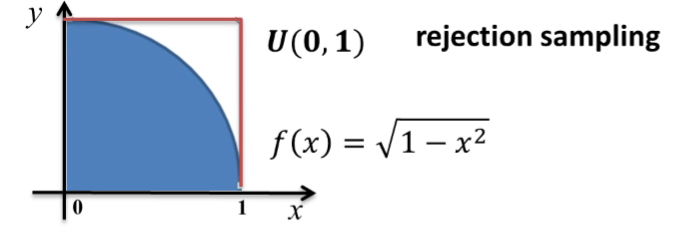

In [ ]:
import random 

def cal_pi(N): 
    count = 0
    for i in range(N):
      x = random.random()
      y = random.random()
      if x**2 + y ** 2 <= 1: 
          count +=1
    return 4 * count / N
    
cal_pi(1000000)

3.139204

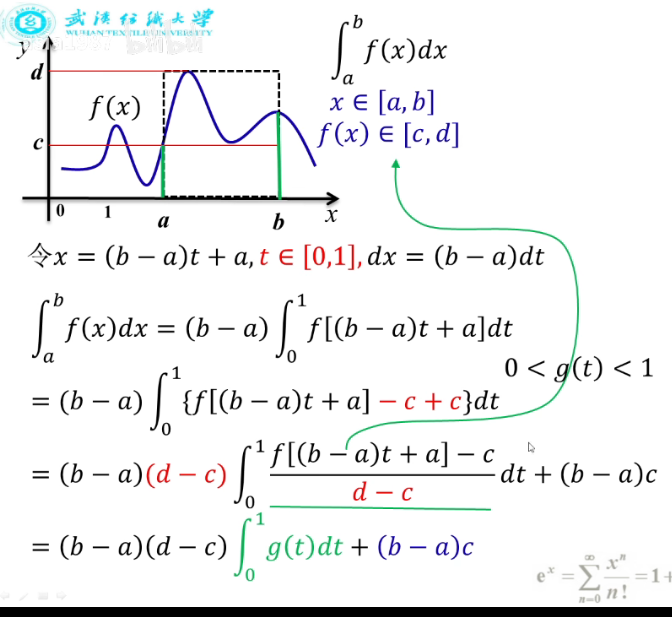

In [5]:
import numpy as np

def f(x):
    return x**2

def solve_int(f, a, b, N):
    
    def rand(a, b, N):
        return np.random.random(N) * (b - a) + a
    
    def g(f, t, a, b, c, d):
        return (f((b - a) * t + a) - c) / (d - c)
    
    x = rand(a, b, N)
    c = np.min(f(x))
    d = np.max(f(x))
    
    t = rand(0, 1, N)
    y = rand(0, 1, N)
    count = np.sum(g(f, t, a, b, c, d) > y)
    
    return (b - a) * (d - c) * (count / N)  + (b - a) * c

solve_int(f, 0, 5, 1000000)

41.698334237298944

## 4.2 定积分-重要性采样
$$
\int_{a}^{b} f(x) d x=\int_{a}^{b} \frac{f(x)}{g(x)} g(x) d x
$$
若$g(x)$是某个概率密度分布函数，令$Z = \frac{f(x)}{g(x)}$则有
$$
\begin{aligned}
E(Z)&=\frac{1}{N} \sum_{i=1}^{N} Z_{i}=\frac{1}{N} \sum_{i=1}^{N} \frac{f\left(x_{i}\right)}{g_{1}\left(x_{i}\right)} \\
&=\frac{b-a}{N} \sum_{i=1}^{N} f\left(x_{i}\right)
\end{aligned}
$$

In [4]:
import numpy as np

def f(x):
    return x**2

def solve_int_2(f, a, b, N):
    
    def rand(a, b, N):
        return np.random.random(N) * (b - a) + a
    
    x = rand(a, b, N)
    
    # 相当于积分中值定理
    return (b - a) * np.mean(f(x))
solve_int_2(f, 0, 5, 1000000)

41.617279220098865

# 5 参数估计

## 5.1 回归参数估计常用方法
- 最小二乘法
- 极大似然

## 5.2 基于吉布斯采样的MCMC回归参数估计
统计模型
$$y = ax + b + \varepsilon$$
我们需要求概率分布为
$$P(a,b,\sigma^2| y,x)$$
使用三维分布的吉布斯采样,对$b$而言，
$$P(b|y, x, a, \sigma^2) \propto P(y,x | b, a, \sigma^2)P(b)$$
而在统计模型中
$$
\varepsilon  \sim N(0, \sigma^2) \\ 
y_i \sim N(a x_i + b, \sigma^2) \\ 
P\left(y_{i}, x_{i} \mid b, a, \sigma^{2}\right)=\frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{\left(y_{i}-a x_{i}-b\right)^{2}}{2 \sigma^{2}}}
$$

<ipython-input-43-3230fb0b3ddf>:29: RuntimeWarning: divide by zero encountered in double_scalars
  b_sigma = (sigma + n * sigma0) /(sigma * sigma0)
<ipython-input-43-3230fb0b3ddf>:36: RuntimeWarning: invalid value encountered in double_scalars
  a_mu = (mu1 * sigma + sigma1 * np.sum((y - b) * x)) / (sigma + sigma1 * np.sum(x**2))
<ipython-input-43-3230fb0b3ddf>:37: RuntimeWarning: invalid value encountered in double_scalars
  a_sigma = (sigma * sigma1) / (sigma + sigma1 * np.sum(x**2))


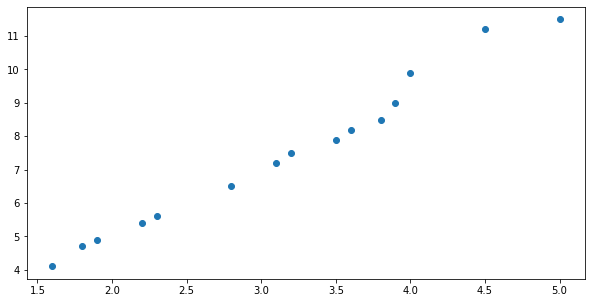

In [43]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
# 数据
x = np.asarray([1.6, 1.8, 1.9, 2.2, 2.3, 2.8, 3.1, 3.2, 3.5, 3.6,
                3.8, 3.9, 4.0, 4.5, 5.0])

y = np.asarray([4.1, 4.7, 4.9, 5.4, 5.6, 6.5, 7.2, 7.5, 7.9, 8.2, 8.5,
                9.0, 9.9, 11.2,11.5])

n = x.size
# 初始化
a = 1
b = 1
sigma = 1

mu0 = 1
sigma0 = 1
mu1 = 1
sigma1 = 1
alpha = 2
beta = 1
N = 100
bList = []
aList = []
for i in range(N):
    # 估计 b
    b_mu = (mu0 * sigma0 + np.sum(y - a*x)) / (sigma + n * sigma0)
    b_sigma = (sigma + n * sigma0) /(sigma * sigma0)
    b = np.random.normal(b_mu, np.sqrt(b_sigma))
    mu1 = b_mu
    sigma1 = b_sigma
    bList.append(b)
    
    # 估计 a
    a_mu = (mu1 * sigma + sigma1 * np.sum((y - b) * x)) / (sigma + sigma1 * np.sum(x**2))
    a_sigma = (sigma * sigma1) / (sigma + sigma1 * np.sum(x**2))
    a = np.random.normal(a_mu, np.sqrt(a_sigma))
    mu0 = a_mu
    sigma0 = a_sigma
    aList.append(a)
    
    # 估计 sigma
    sigma_alpha = alpha + n * 0.5
    sigma_beta  = beta + 0.5 * np.sum((y - a * x - b) ** 2)
    sigma = 1 / np.random.gamma(sigma_alpha, sigma_beta)
    alpha = sigma_alpha
    beta  = sigma_beta
    
# 取各参数平衡后的样本值，求均值即为参数的估计值
a = np.asarray(aList[-100:]).sum()
b = np.asarray(bList[-100:]).sum()

x0 = np.linspace(0,10,200)
y0 = a * x0 + b
plt.plot(x0,y0)
plt.scatter(x,y)

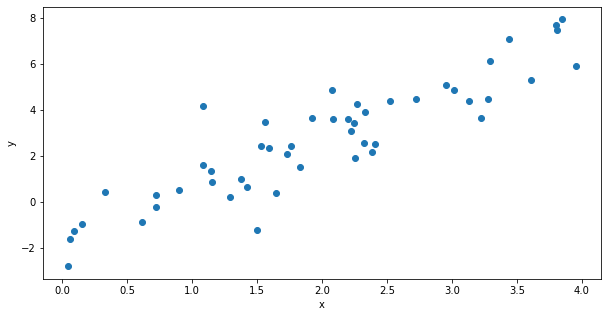

In [39]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}


def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

iters = 1000
trace = gibbs(y, x, iters, init, hypers)



Text(0, 0.5, 'Parameter value')

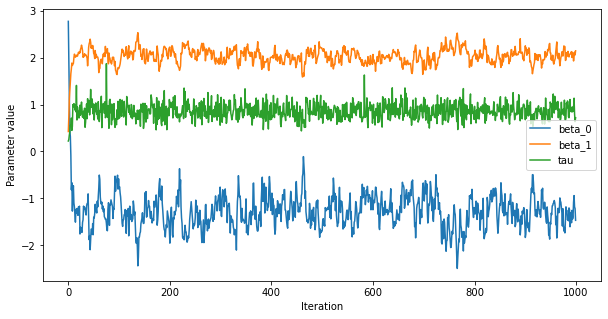

In [40]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

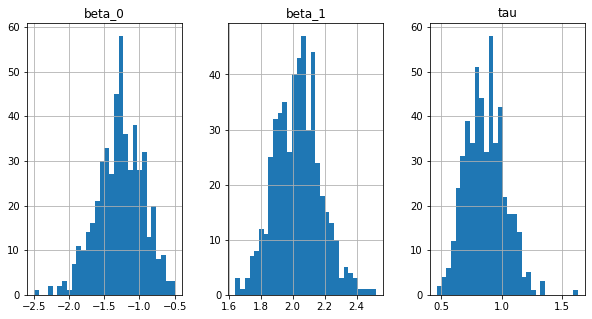

In [41]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

# 6 pymc3

## 6.1 基础
### 6.1.1 后验估计

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

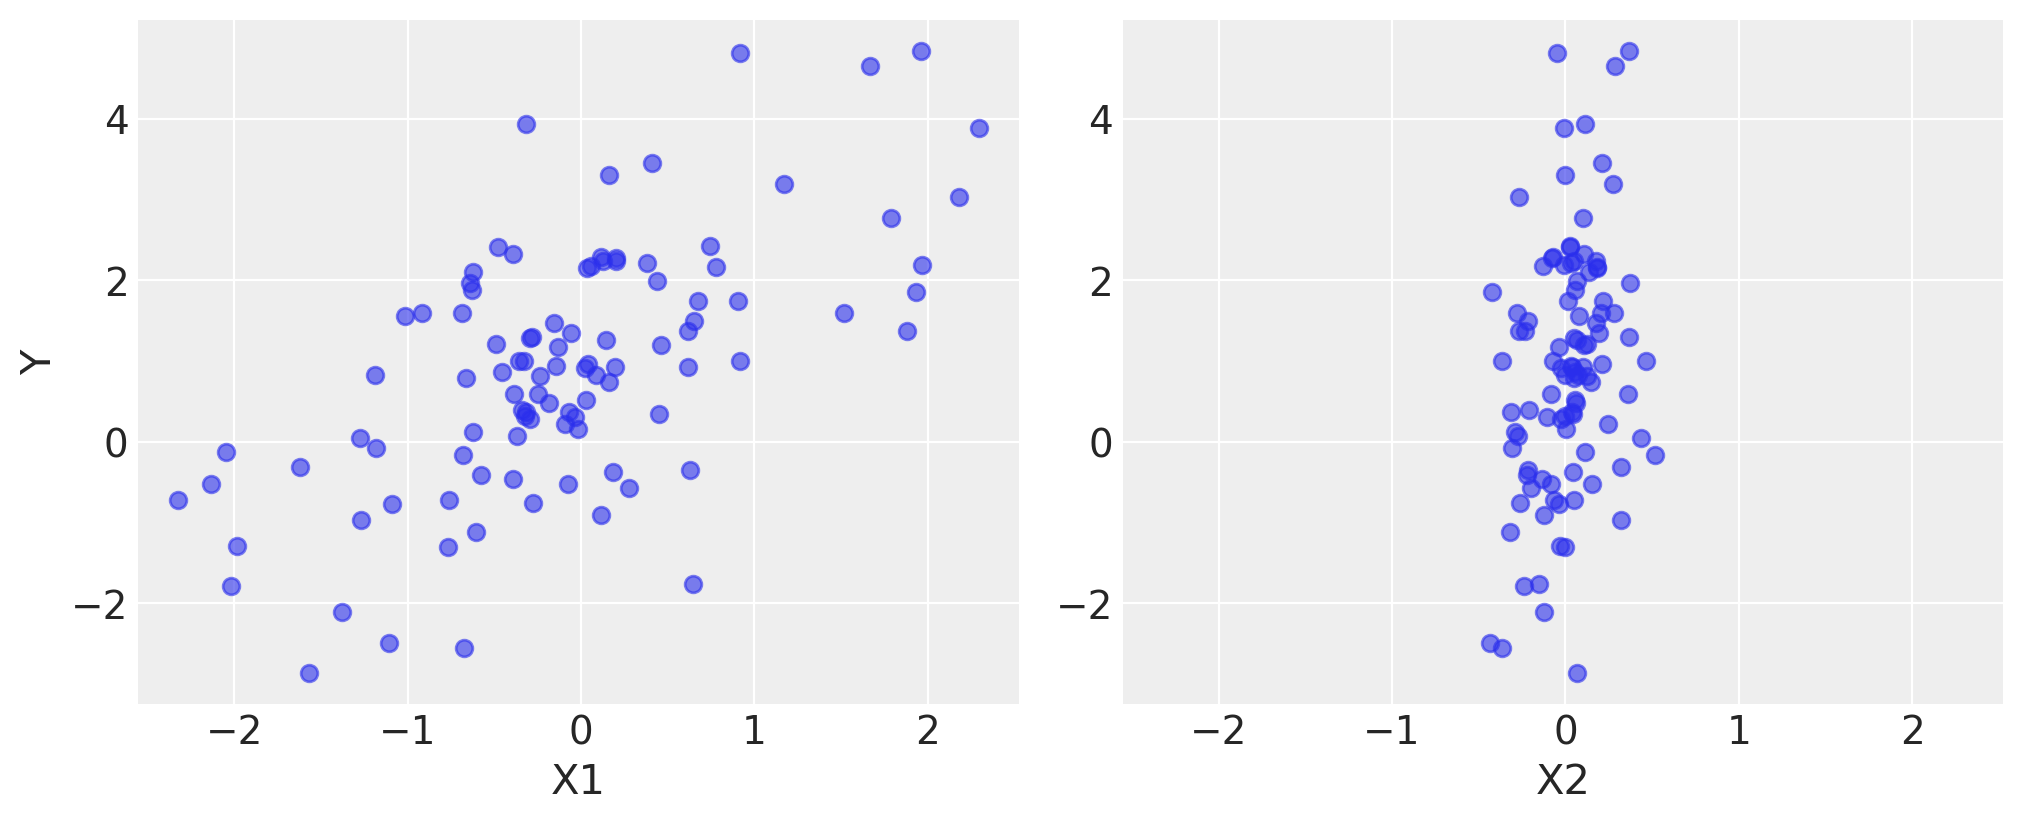

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [6]:
import pymc3 as pm
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(0.95724679),
 'beta': array([1.10071814, 2.9511438 ]),
 'sigma_log__': array(0.03540151),
 'sigma': array(1.0360356)}

In [8]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate

D:\Anaconda\lib\site-packages\scipy\optimize\_minimize.py:519: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma_log__': array(0.03638187),
 'sigma': array(1.03705179)}

### 6.1.2 基于梯度的采样方法
PyMC3 最强大的步进方法是 No-U-Turn Sampler。NUTS 在具有许多连续参数的模型上特别有用，在这种情况下，其他 MCMC 算法工作非常缓慢。

In [9]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 17 seconds.


In [10]:
trace["alpha"][-5:]

array([1.05903288, 1.00385511, 0.80612402, 0.63172018, 0.70969144])

### 6.1.3 后验分析
PyMC3的绘图和诊断功能现在由名为ArviZ的与平台无关的专用软件包处理。可以使用创建一个简单的后验图plot_trace。

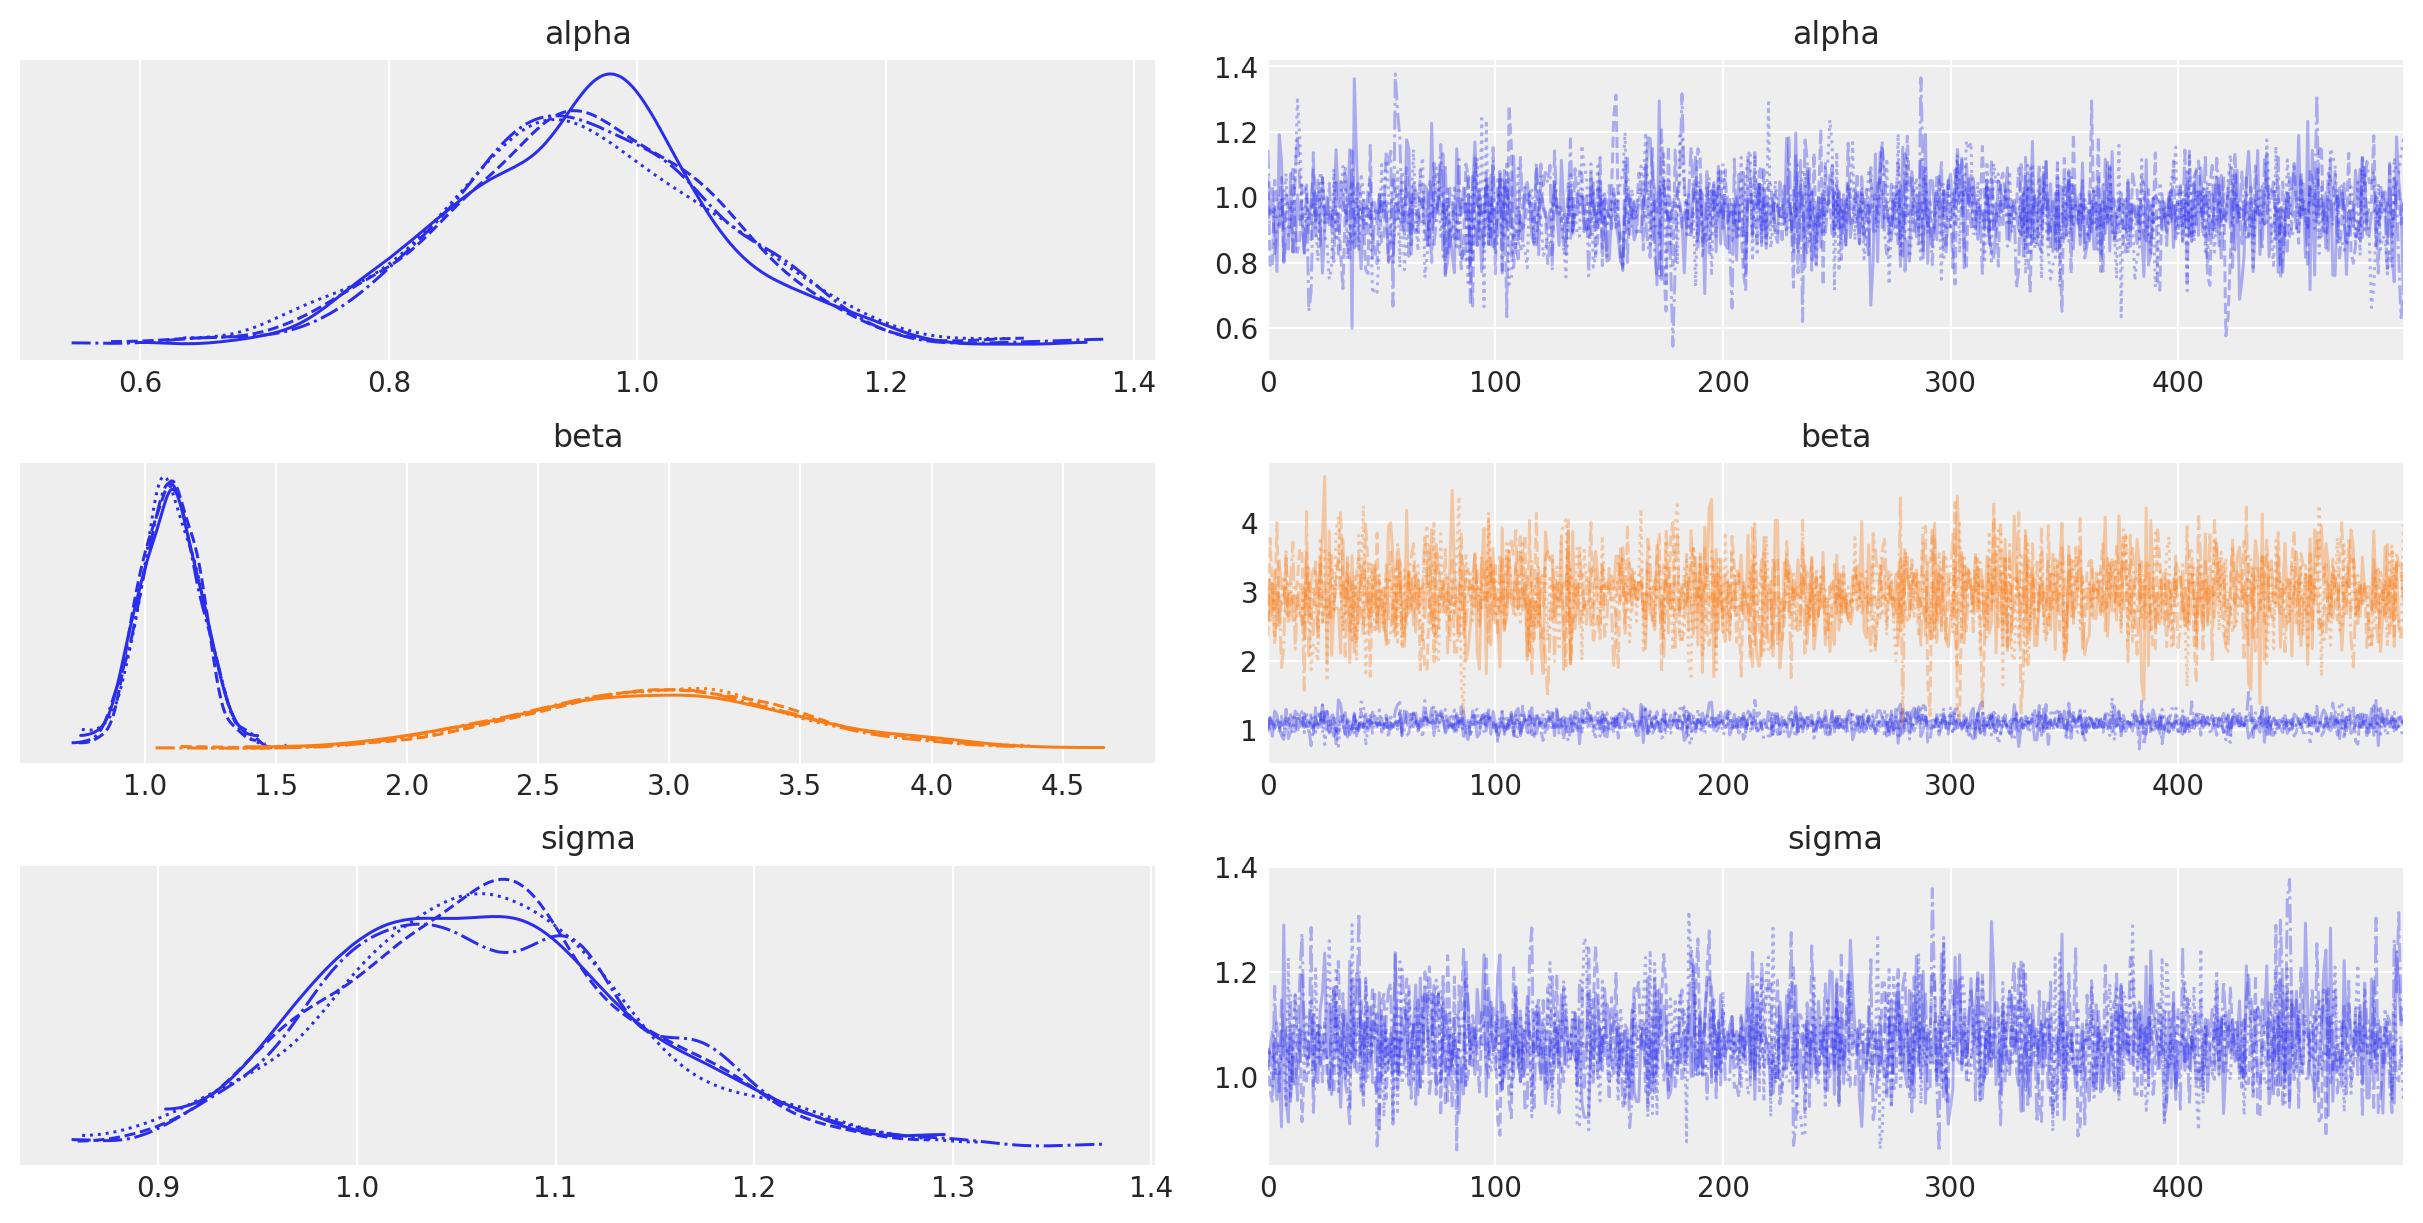

In [11]:
# 常见的后验分布图
with basic_model:
    az.plot_trace(trace);

In [12]:
# 文字说明版
with basic_model:
    display(az.summary(trace, round_to=2))

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha    0.96  0.11    0.75     1.15       0.00     0.00   2712.11   1641.06   
beta[0]  1.10  0.11    0.90     1.31       0.00     0.00   2758.47   1623.16   
beta[1]  2.95  0.52    2.08     4.03       0.01     0.01   3031.64   1341.60   
sigma    1.07  0.08    0.92     1.21       0.00     0.00   2483.16   1242.63   

         r_hat  
alpha      1.0  
beta[0]    1.0  
beta[1]    1.0  
sigma      1.0

## 6.2 例子
### 6.2.1 随机波动率
我们提出了一个随机波动率、随时间变化的股票市场波动率的案例研究，以说明 PyMC3 在解决更现实问题中的用途。市场收益的分布是高度非正态的，这使得对波动率进行抽样变得更加困难。此示例有 400 多个参数，因此使用 Metropolis-Hastings 等常见采样算法会陷入困境，生成高度自相关的样本。相反，我们使用 NUTS，它的效率大大提高。

资产价格具有随时间变化的波动性（每天的变化returns）。在某些时期，回报是高度可变的，而在其他时期则非常稳定。随机波动率模型通过一个随时间变化的潜在波动率变量来解决这个问题。以下模型类似于 NUTS 论文 (Hoffman 2014, p. 21) 中描述的模型。
$$
\begin{aligned}
\nu & \sim \exp (0.1) \\
\sigma & \sim \exp (50) \\
s_{i} & \sim \mathcal{N}\left(s_{i-1}, \sigma^{2}\right) \\
\log \left(r_{i}\right) & \sim t\left(\nu, 0, \exp \left(-2 s_{i}\right)\right)
\end{aligned}
$$


In [13]:
import pandas as pd
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0, usecols=["Date", "change"]
)
len(returns)

2906

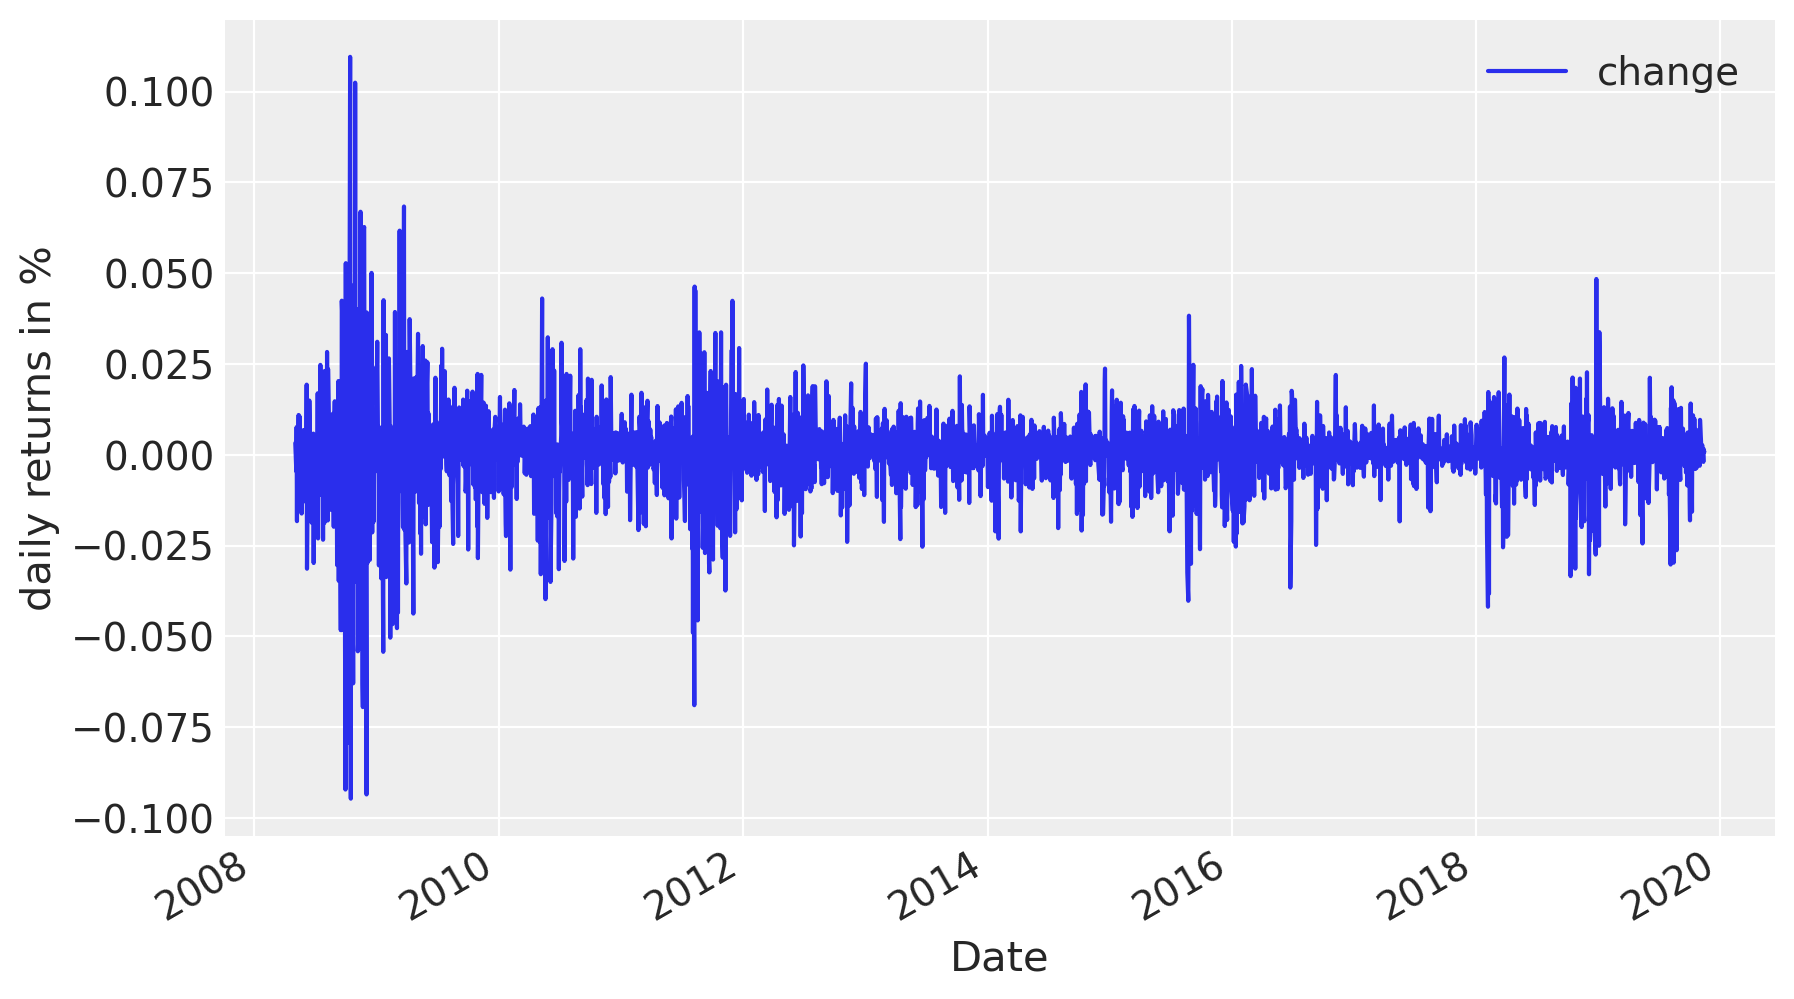

In [14]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    returns.plot(figsize=(10, 6))
    plt.ylabel("daily returns in %");

In [15]:
with pm.Model() as sp500_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = pm.Data("returns", returns["change"], dims="date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date")

In [28]:
with sp500_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 321 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


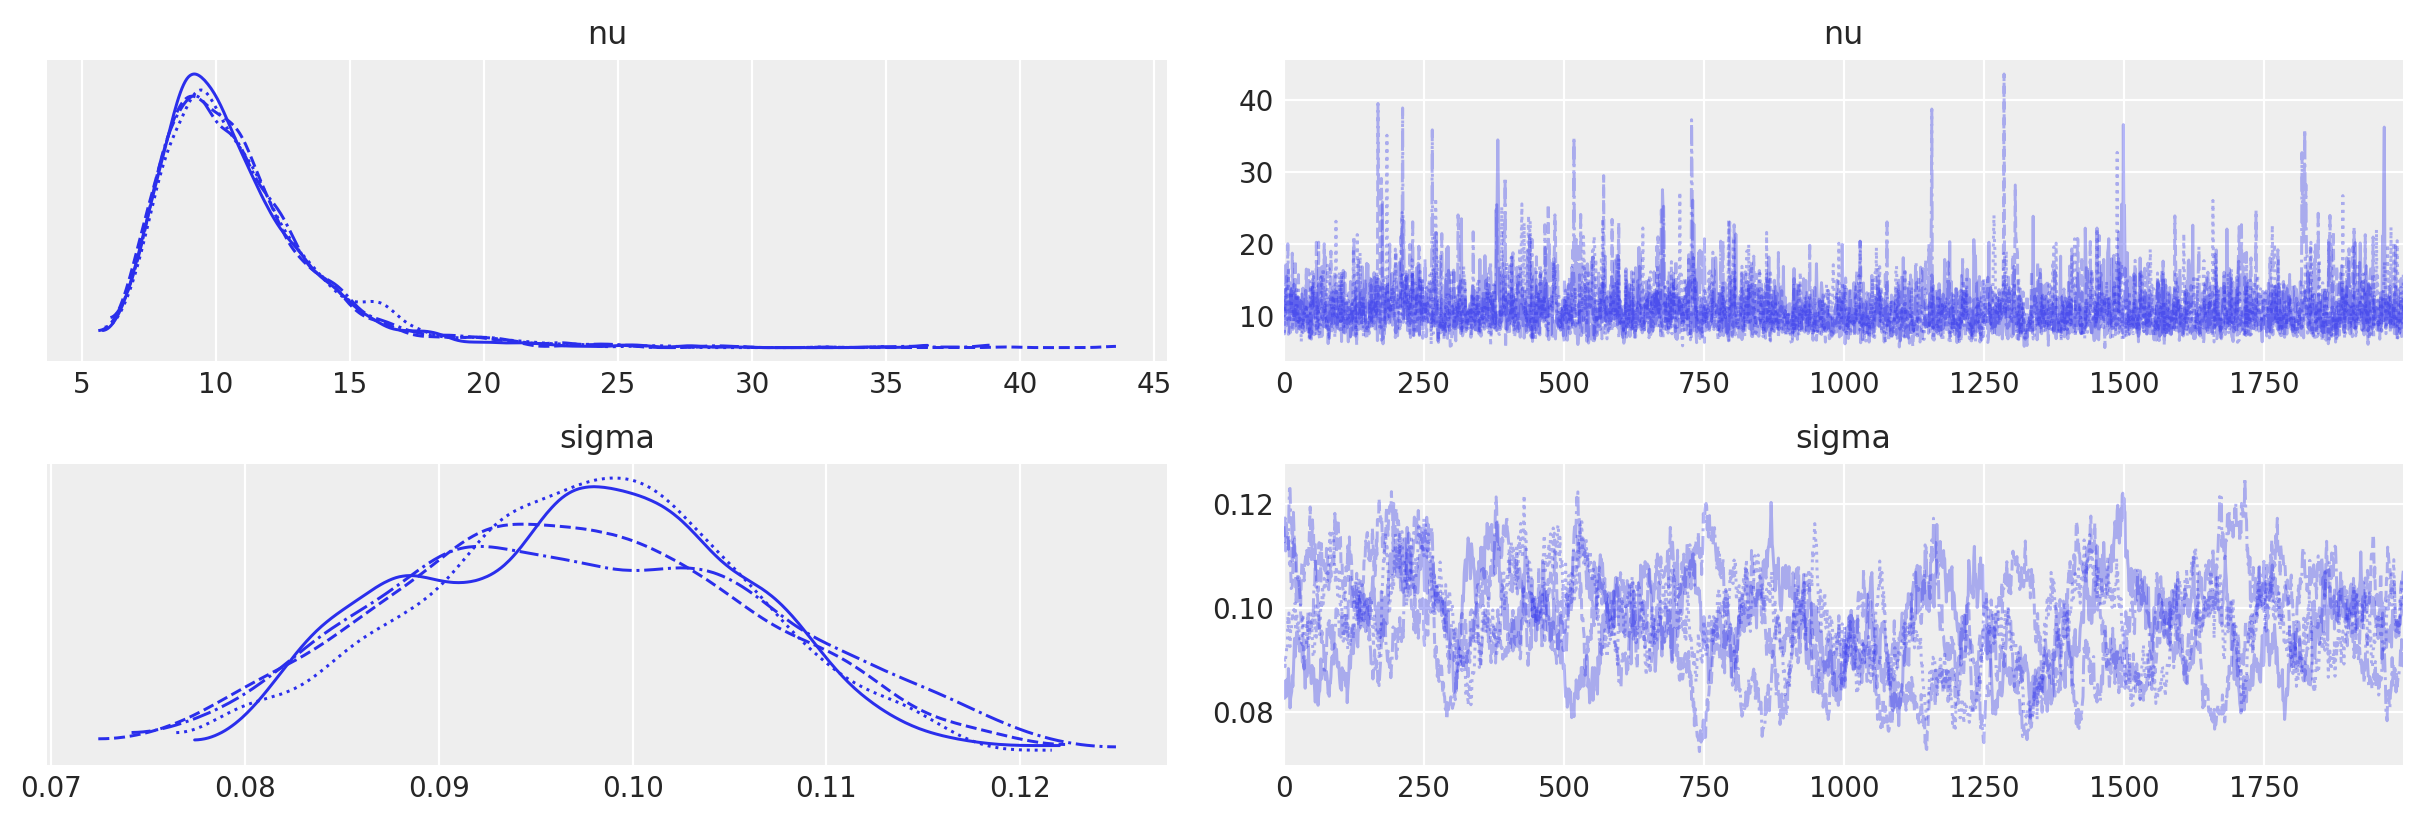

In [38]:
with sp500_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

D:\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\tools.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(bottom=0.2)


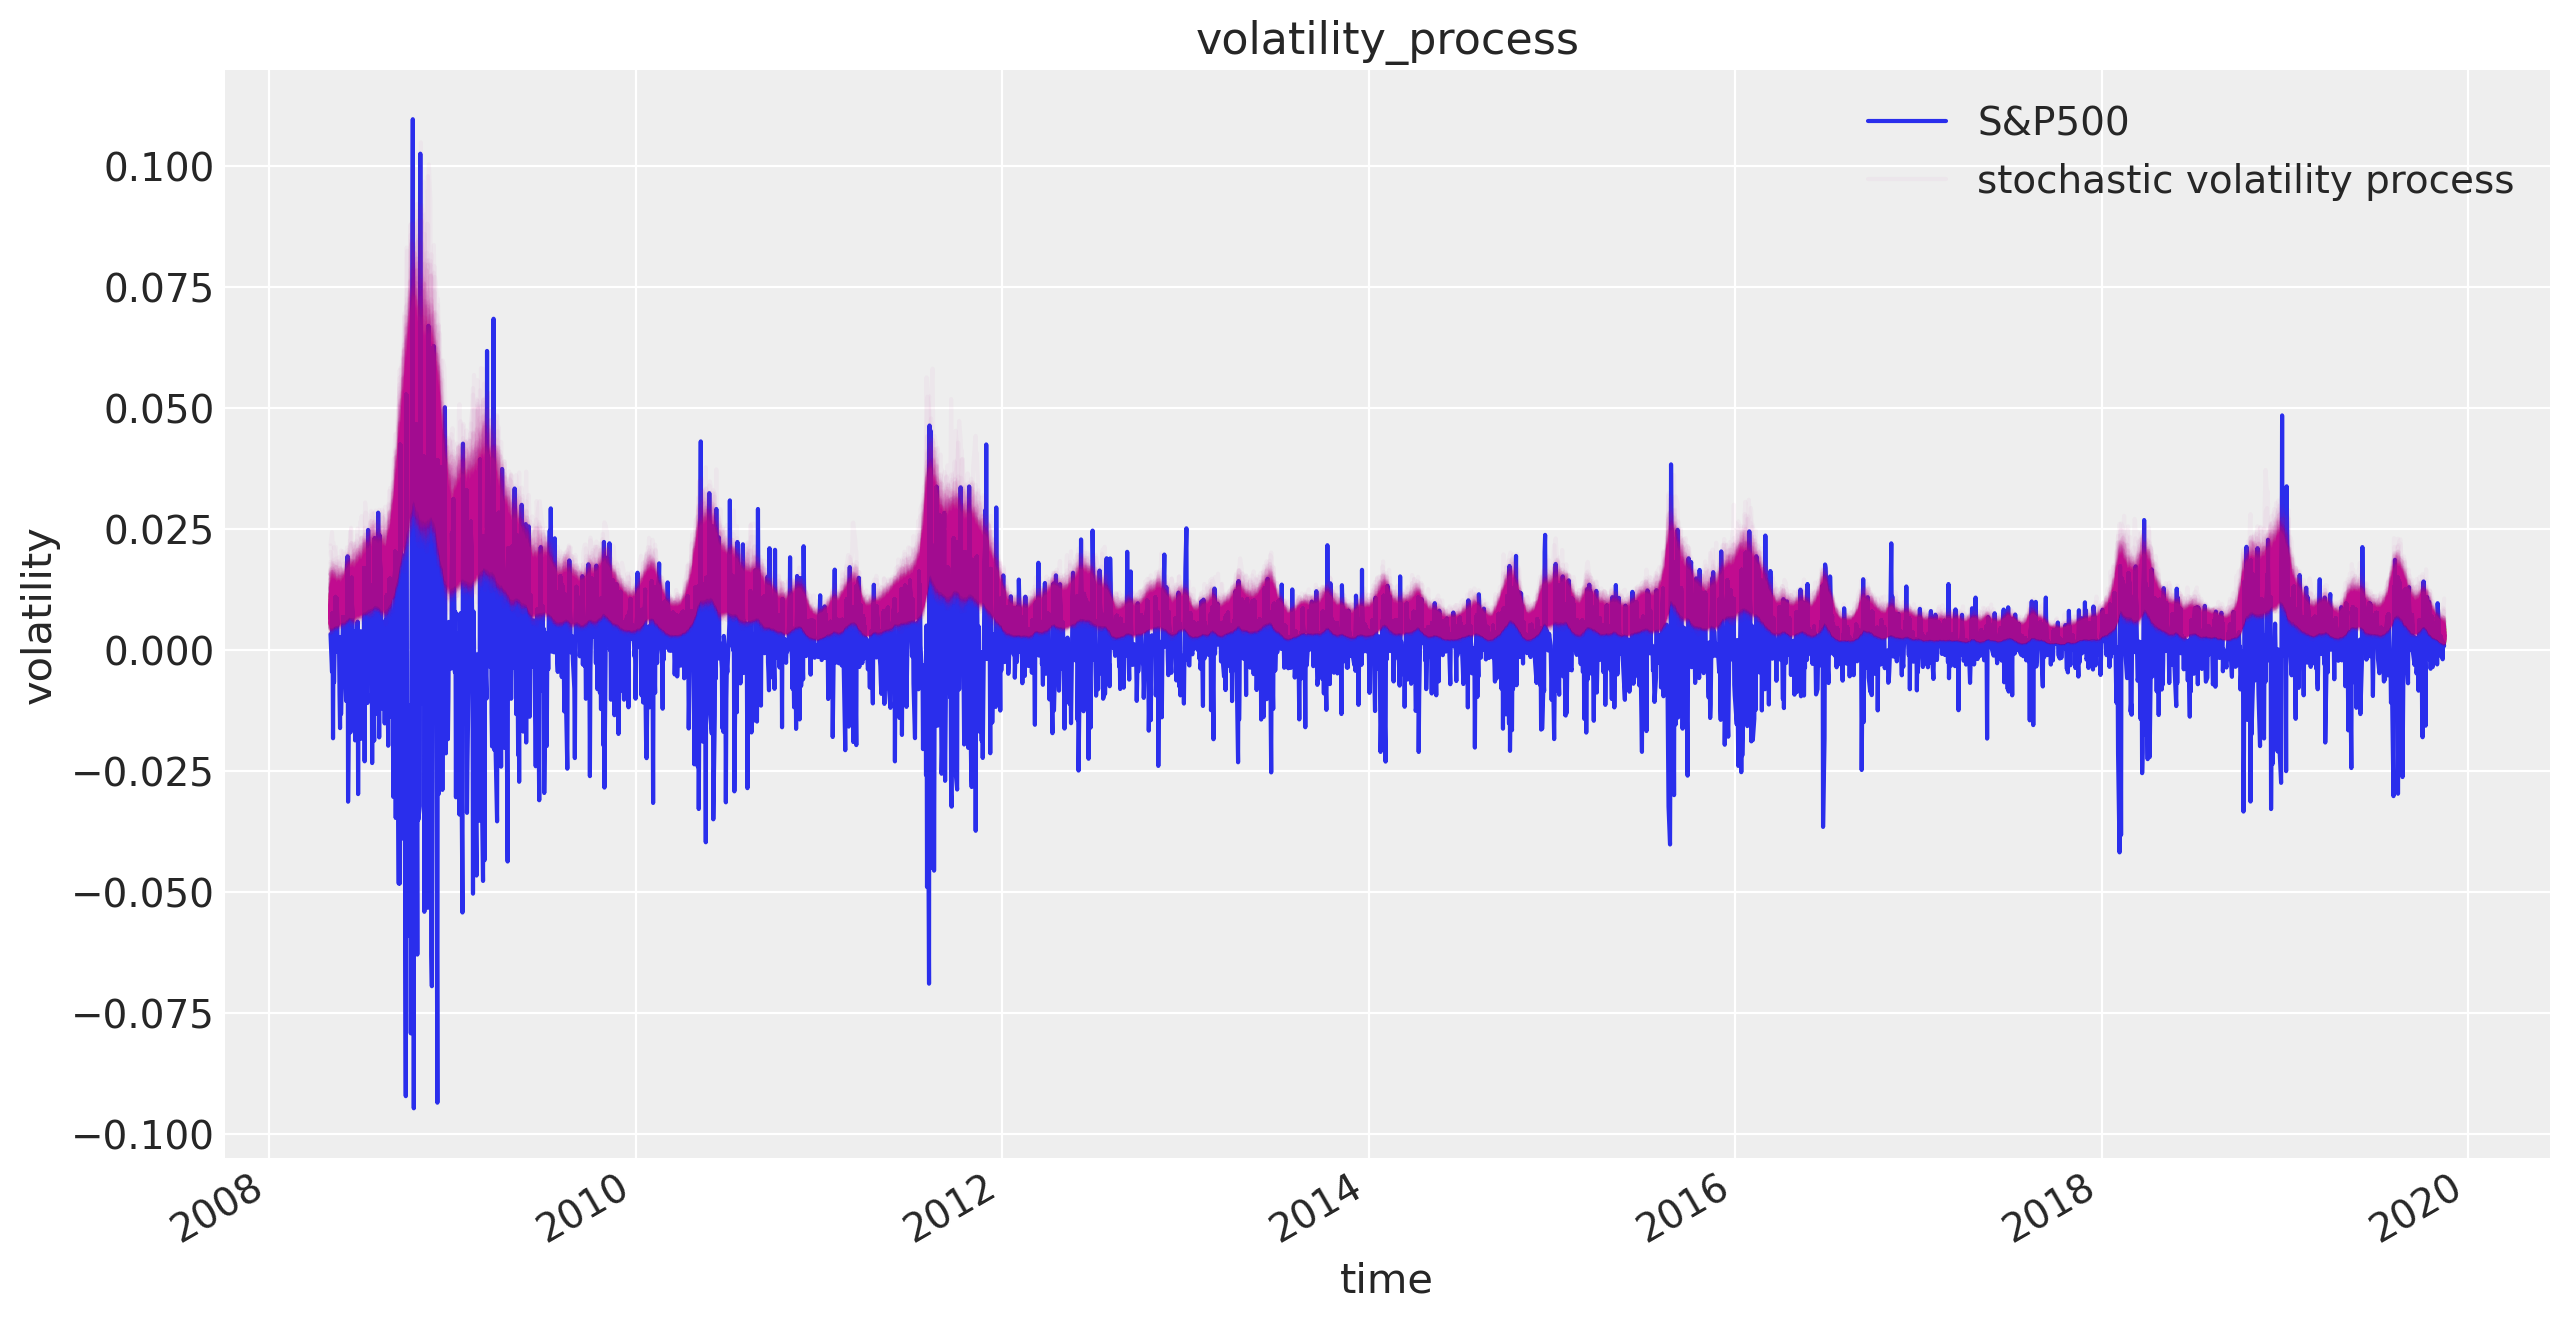

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["S&P500", "stochastic volatility process"], loc="upper right");

如您所见，该模型正确地推断出 2008 年金融危机期间波动性的增加。此外，请注意，该模型非常复杂，因为它在随机游走分布中具有高维度和依赖结构。然而，在 PyMC3 中实现的 NUTS 可以轻松地正确推断后验分布。

### 6.2.2 矿井灾难

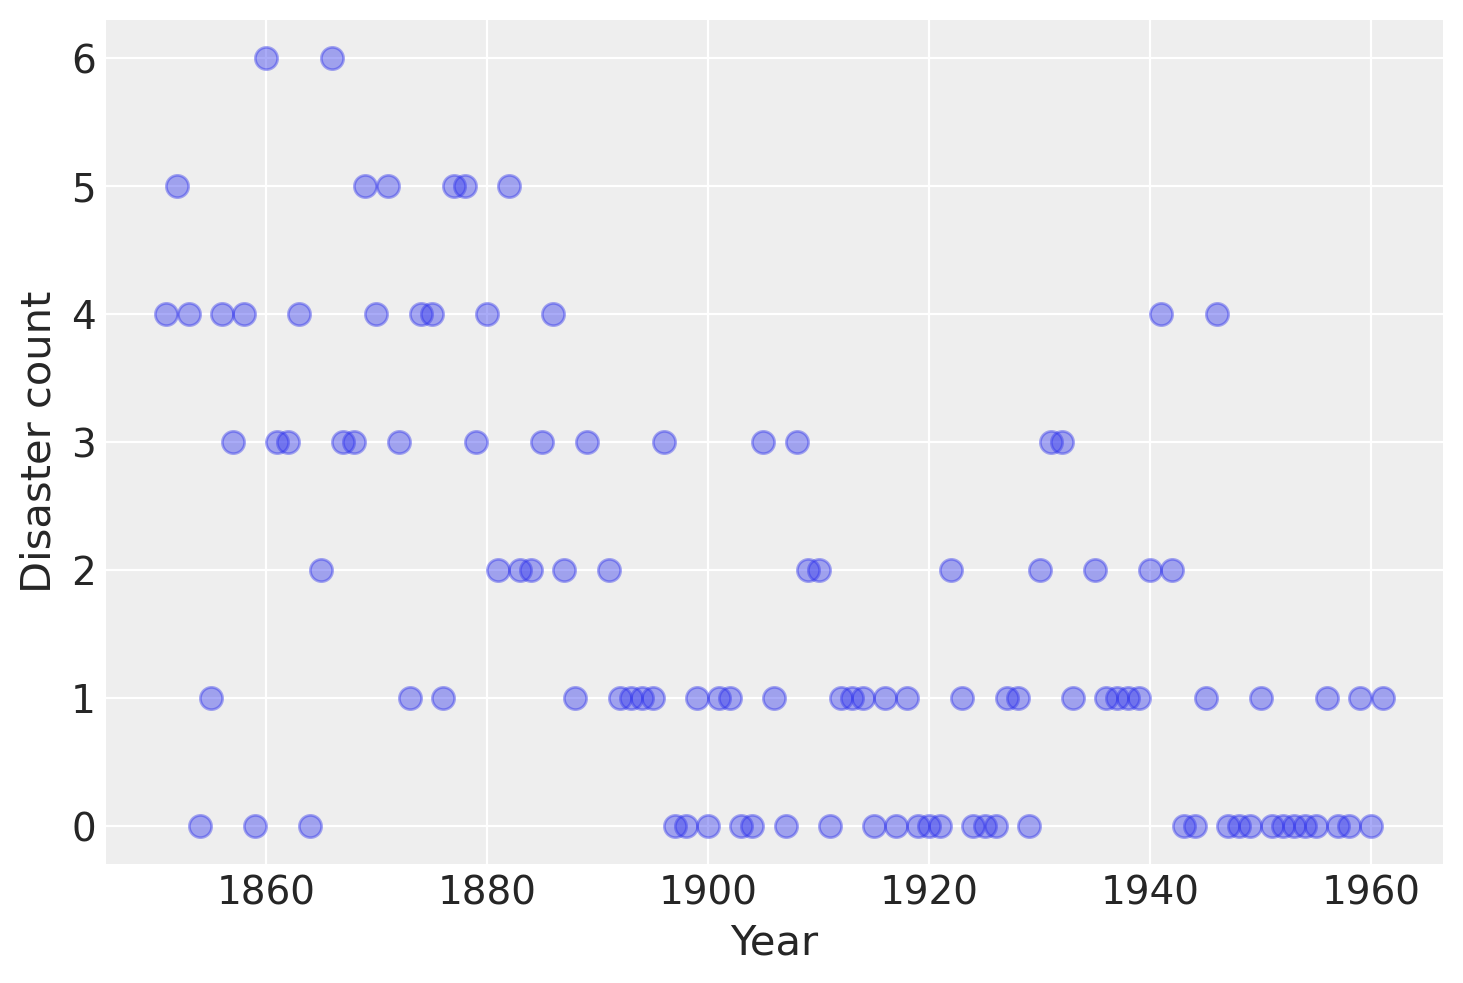

In [55]:
import pandas as pd

# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

时间序列中灾害的发生被认为遵循泊松过程，在时间序列的前半部分具有较大的速率参数，而在后半部分则从较小的速率参数开始。我们有兴趣定位系列中的变化点，这可能与采矿安全法规的变化有关。
而我们所构建的模型中,
$$
\begin{aligned}
D_{t} & \sim \operatorname{Pois}\left(r_{t}\right), r_{t}= \begin{cases}e, & \text { if } t \leq s \\
l, & \text { if } t>s\end{cases} \\
s & \sim \operatorname{Unif}\left(t_{l}, t_{h}\right) \\
e & \sim \exp (1) \\
l & \sim \exp (1)
\end{aligned}
$$
参数定义如下: $D_t$——当年灾害次数，$r_t$灾害年泊松分布的速率参数.$e$速率参数变化的年份(切换点)。$e$切换点前的速率参数.$l$切换点后的速率参数。$t_l$,$t_h$年份的上下边界.

In [57]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900
    )

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

D:\Anaconda\lib\site-packages\pymc3\model.py:1755: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [58]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 35 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [59]:
with disaster_model:
    idata = az.from_pymc3(trace)

In [60]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

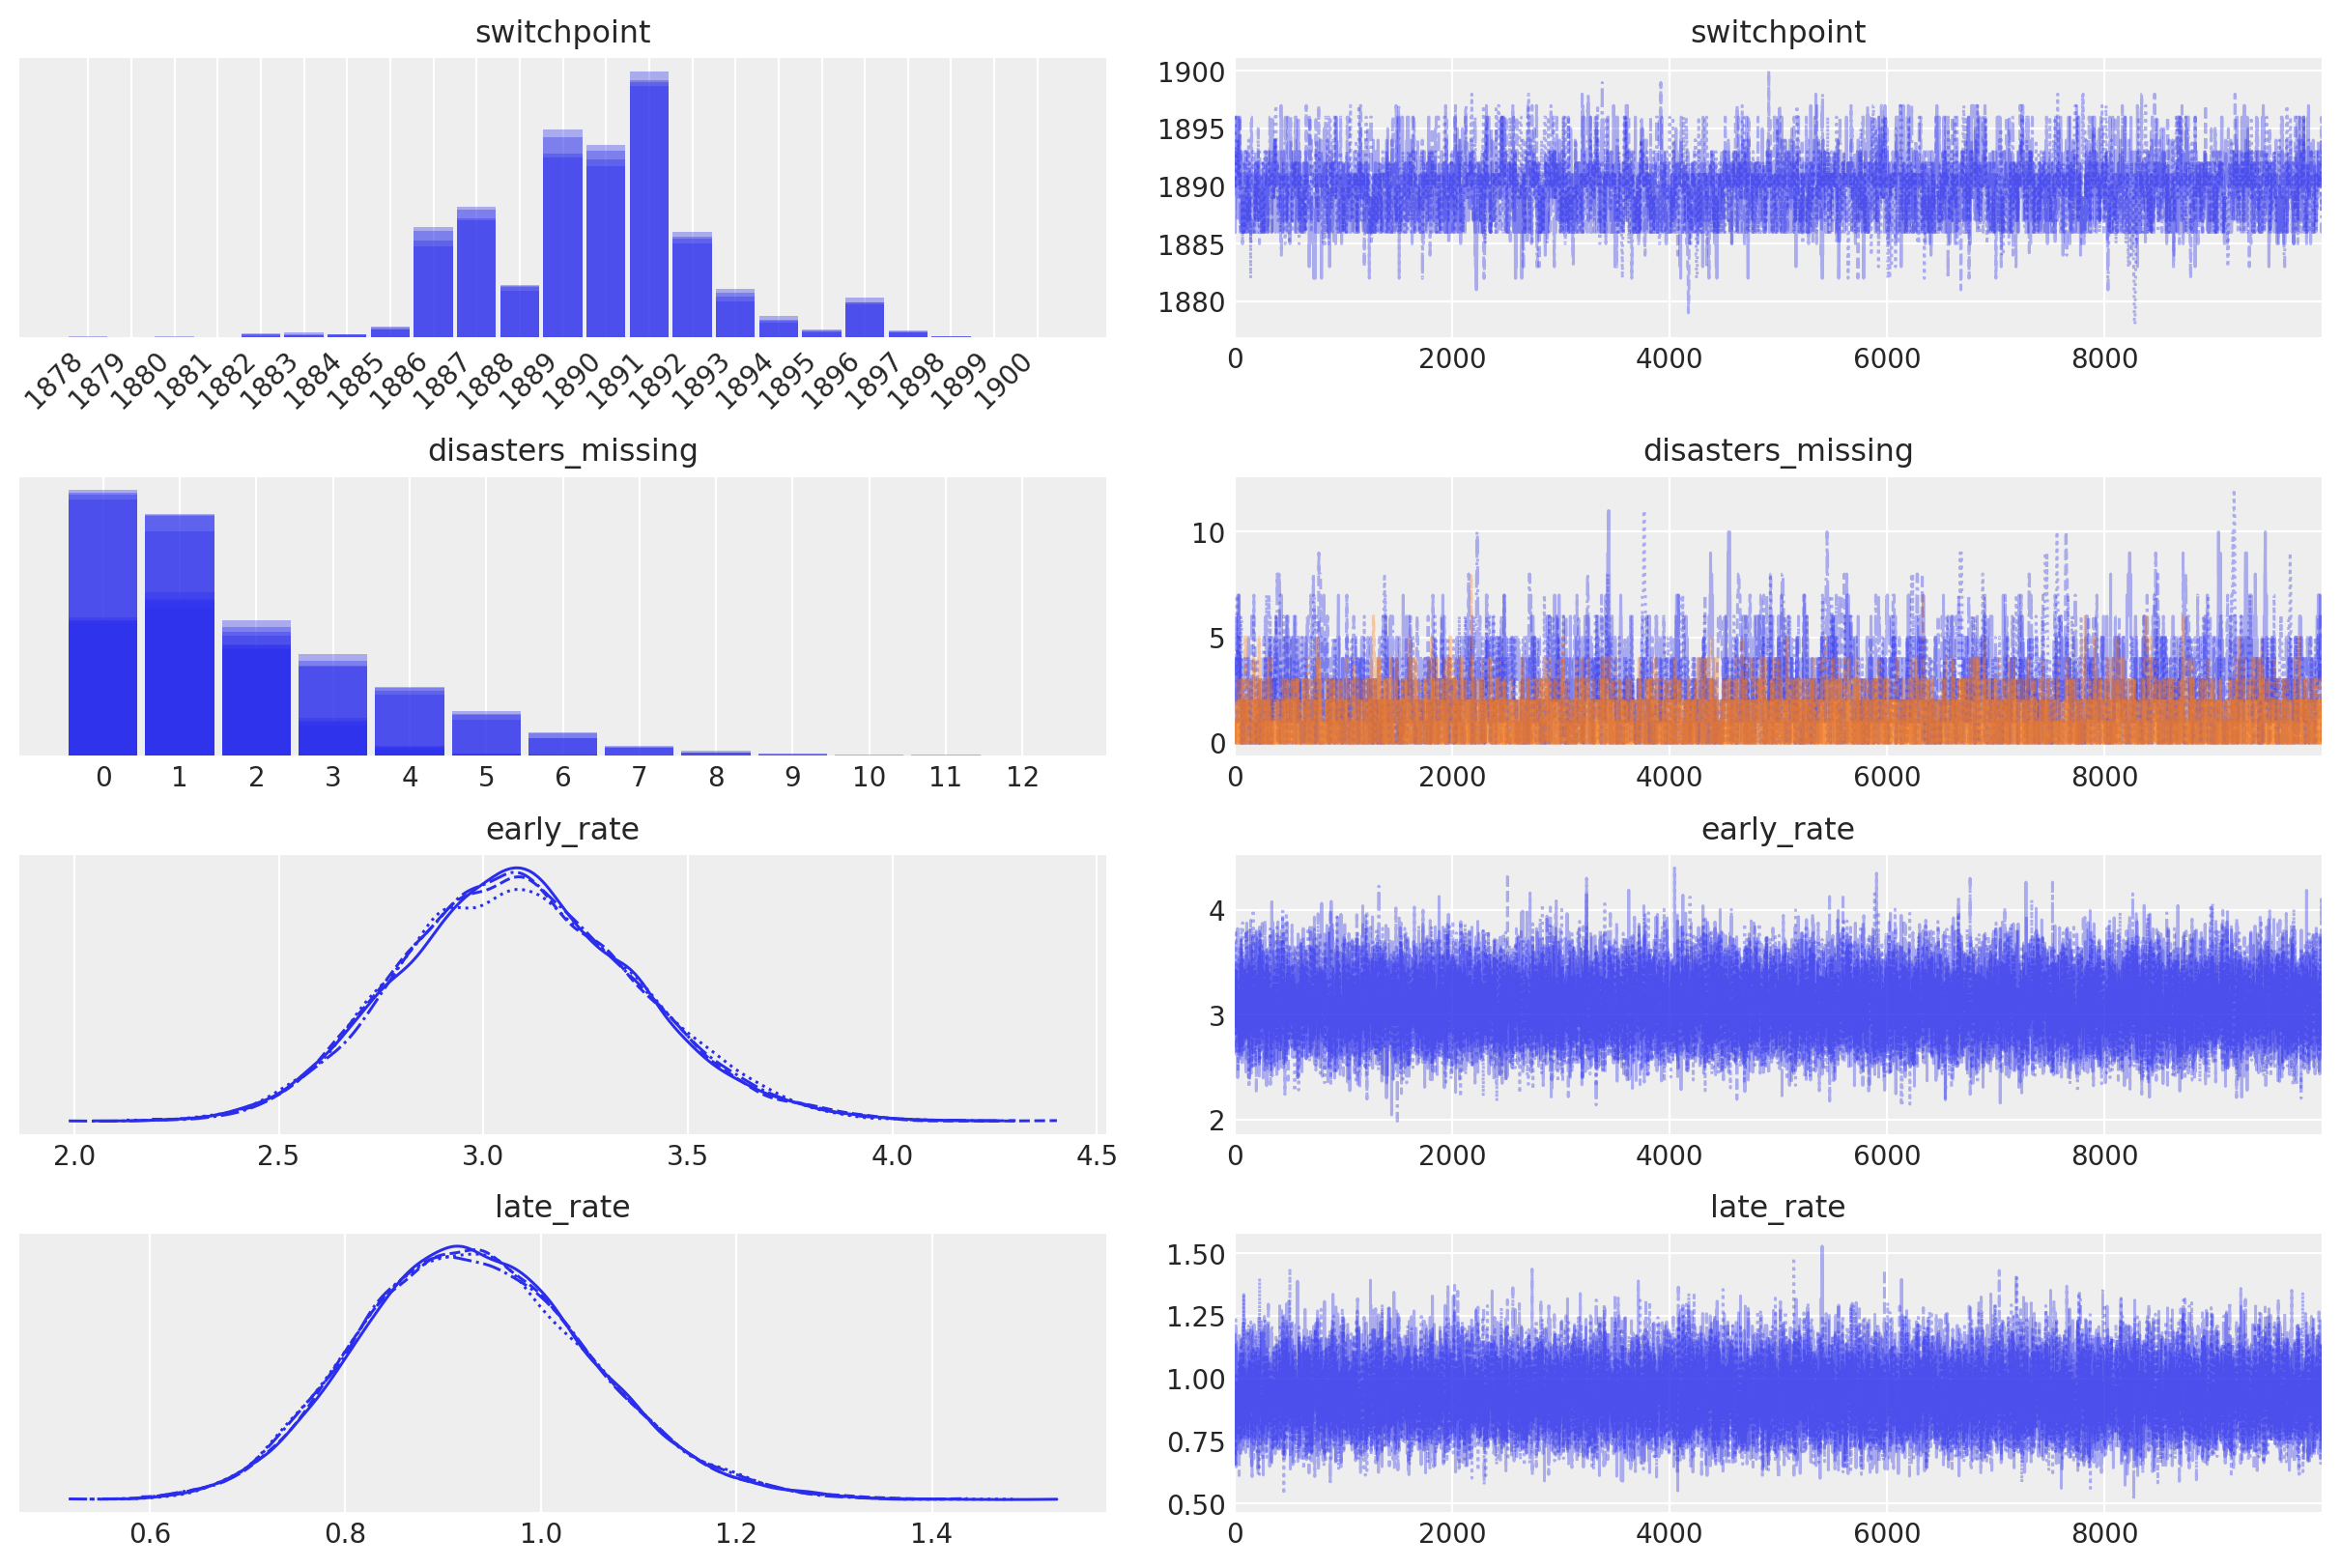

In [61]:
with disaster_model:
    axes_arr = az.plot_trace(trace)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

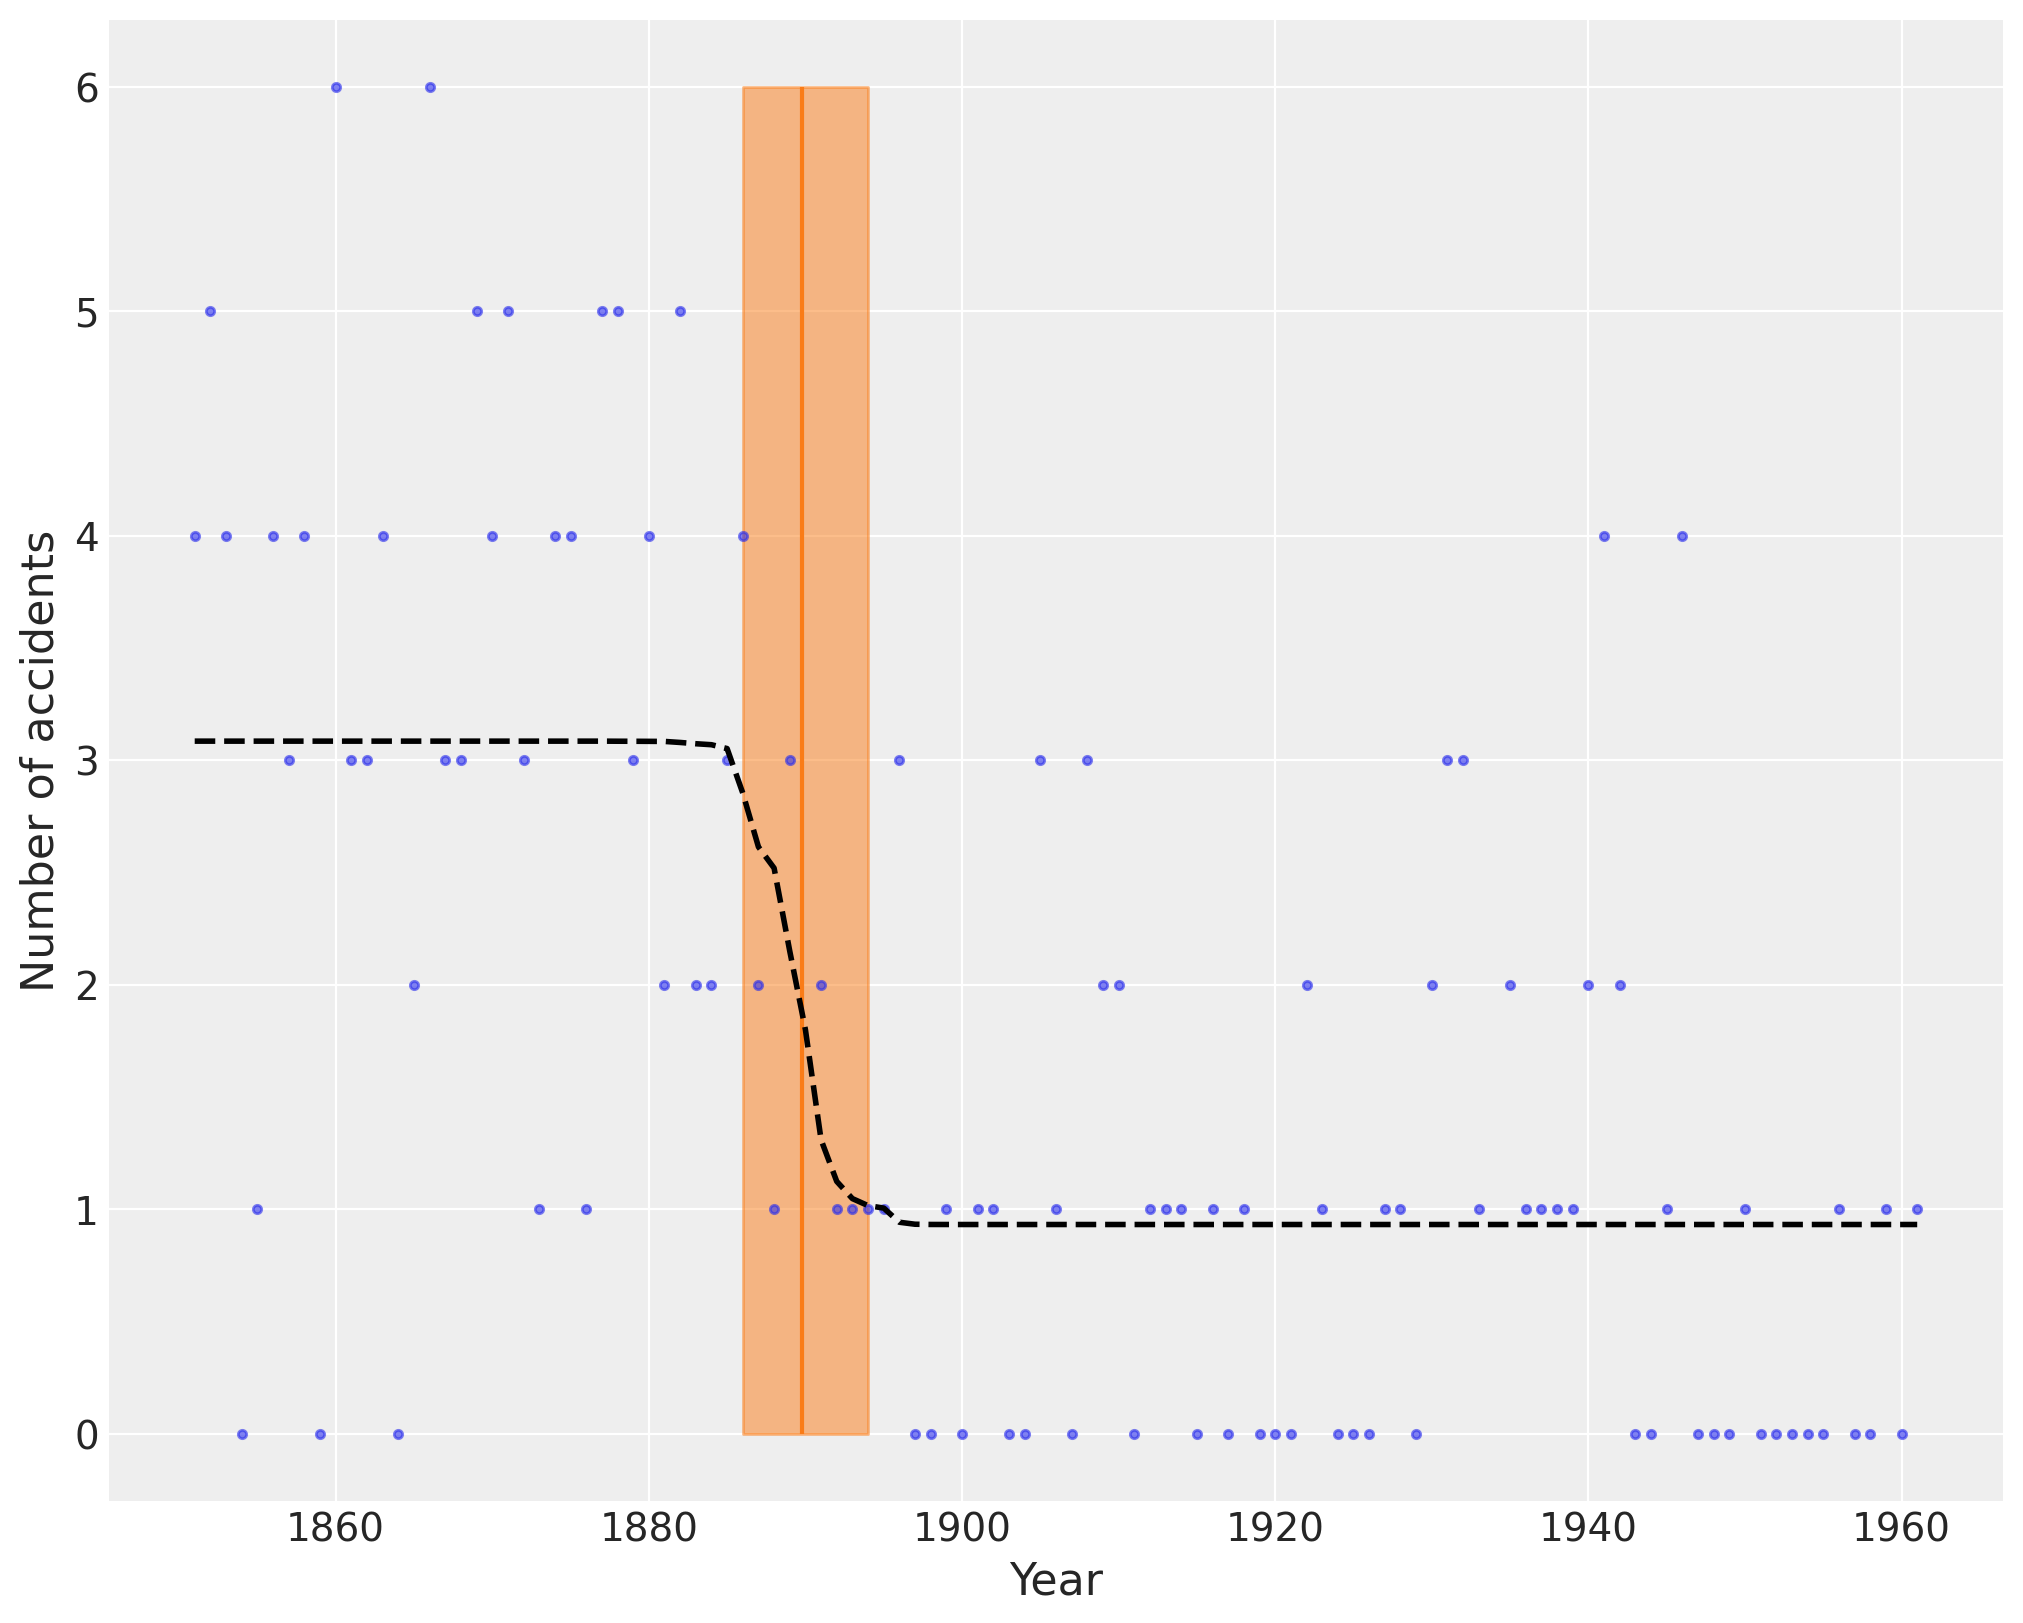

In [62]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], 
                                            trace["late_rate"]))

sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);

## 6.3 任意确定性
由于对 Theano 的依赖，PyMC3 提供了许多数学函数和运算符，用于将随机变量转换为新的随机变量。然而，Theano 中的函数库并不详尽，因此 Theano 和 PyMC3 提供了在纯 Python 中创建任意 Theano 函数的功能，并将这些函数包含在 PyMC 模型中。as_op函数装饰器支持这一点。

Theano 需要知道函数的输入和输出的类型，这些类型as_op由itypesfor input 和otypesfor outputs 指定。Theano 文档包括可用类型的概述。

In [63]:
import theano.tensor as tt

from theano.compile.ops import as_op


@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else:
        return (-value + 1) % 3


with pm.Model() as model_deterministic:
    a = pm.Poisson("a", 1)
    b = crazy_modulo3(a)

这种方法的一个重要缺点是无法theano检查这些函数来计算基于哈密顿量的采样器所需的梯度。因此，不可能将 HMC 或 NUTS 采样器用于使用此类运算符的模型。但是，如果我们继承自theano.Op而不是使用，则可以添加渐变as_op。PyMC 示例集包括更详细的 as_op 用法示例。

## 6.4 任意分布
同样，PyMC3 中的统计分布库并不详尽，但 PyMC3 允许为任意概率分布创建用户定义的函数。对于简单的统计分布，该DensityDist函数将任何计算对数概率的函数作为参数. 该函数可以在其计算中使用其他随机变量。这是一个示例，灵感来自 Jake Vanderplas 的博客文章，其中先验用于线性回归（Vanderplas，2014）。

In [64]:
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)

    # Create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)

    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sigma=eps, observed=Y)

NameError: name 'X' is not defined